In [1]:
#%matplotlib qt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft 
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pywt

#from scipy.signal import argrelextrema

In [2]:
#Il dataframe finale è 'data'
DataFrame=pd.read_csv("center_sternum.txt",sep=None,engine='python')
DataFrame['time_s'] = np.arange(0,DataFrame.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
DataFrame=DataFrame.set_index('time_s')

df = DataFrame.drop(columns=['Log Mode','Log Freq','Timestamp','MagnX','MagnY','MagnZ','qw','qi','qj','qk'])
data = df.loc[9:71].copy()
print(data.columns)

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'], dtype='object')


In [3]:
#scaling data
dataS = pd.DataFrame(MinMaxScaler().fit_transform(data))
dataS.columns = ['AccXS', 'AccYS', 'AccZS', 'GyroXS', 'GyroYS', 'GyroZS']
#print(dataS)
#dataS.plot(y = ['AccXS', 'AccYS', 'AccZS'])
accS_columns = ['AccXS', 'AccYS', 'AccZS']
gyrS_columns = ['GyroXS', 'GyroYS', 'GyroZS']

In [4]:
#PCA on accS_columns
pca=PCA(n_components=1) # we seek a single signal
# X must be (n_samples,n_features)
pca.fit(dataS[accS_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
Acc = pca.transform(dataS[accS_columns]).reshape(-1)

Percentage of variance due to the selected component: 55.64%


In [5]:
#PCA on gyrS_columns
pca.fit(dataS[gyrS_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
Gyr = pca.transform(dataS[gyrS_columns]).reshape(-1)

Percentage of variance due to the selected component: 61.90%


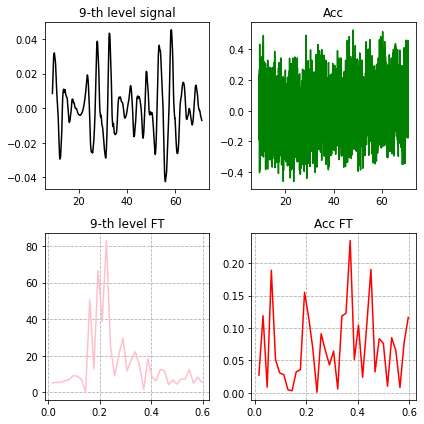

12401 12401
[0.22578824]


In [6]:
#%matplotlib notebook
#9-th order wavelet transform and fourier transform over Acc
db4 = pywt.Wavelet('db4')
n = len(Acc)

cA9A,cD9A,cD8A,cD7A, cD6A,cD5A, cD4A, cD3A, cD2A, cD1A = pywt.wavedec(Acc, db4, level=9)
coefD9A = pywt.upcoef('d',cD9A,'db4',take=n, level=9) #sto ricostruendo il segnale partendo esclusivamenente dai coefficienti
                                                    #details del livello 9. Se ho capito bene, questa è la cosa giusta da fare, veder anche che succede se metto 'a' anzi che 'd'

fft_coefD9A = fft.fft(coefD9A)                          #trasformata di fourier del livello 9
freqA = fft.fftfreq(coefD9A.size, d = 1/200)
maskA = (freqA > 0) & (freqA < 0.6)

power_coefD9A = np.abs(fft_coefD9A)[maskA]
freqA = freqA[maskA]

fft_Acc = fft.fft(Acc)                          #trasformata di fourier di Acc
power_Acc = np.abs(Acc)[maskA]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize = (6,6), nrows = 2, ncols = 2)

ax1.plot(data.index,coefD9A, color = 'black')
ax3.plot(freqA,power_coefD9A, color = 'pink')
ax2.plot(data.index,Acc, color = 'green')
ax4.plot(freqA,power_Acc, color = 'red')

ax1.set_title('9-th level signal')
ax2.set_title('Acc')
ax3.set_title('9-th level FT')
ax4.set_title('Acc FT')

ax3.grid(True,linestyle='--')
ax4.grid(True,linestyle='--')

plt.tight_layout()
plt.show();

print(coefD9A.size,Acc.size)
print(freqA[power_coefD9A == max(power_coefD9A)])

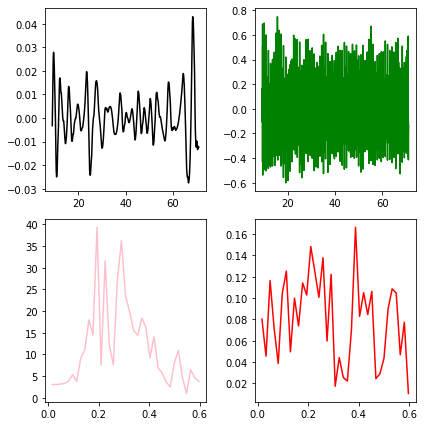

[0.19353278 0.22578824 0.29029917]


In [7]:
#faccio lo stesso su Gyr
cA9G, cD9G, cD8G, cD7G, cD6G, cD5G, cD4G, cD3G, cD2G, cD1G=pywt.wavedec(Gyr, db4, level=9)
#cD9 = pywt.threshold(cD9, value = 0.05, mode='soft', substitute=0) thresholding does not work
coefD9G = pywt.upcoef('d',cD9G,'db4',take=n, level=9) #sto ricostruendo il segnale partendo esclusivamenente dai coefficienti
                                                    #details del livello 9. Se ho capito bene, questa è la cosa giusta da fare, veder anche che succede se metto 'a' anzi che 'd'

fft_coefD9G = fft.fft(coefD9G)                          #trasformata di fourier del livello 9
freqG = fft.fftfreq(coefD9G.size, d = 1/200)
maskG = (freqG > 0) & (freqG < 0.6)
power_coefD9G = np.abs(fft_coefD9G)[maskG]
freqG = freqG[maskG]

fft_Gyr = fft.fft(Gyr)                          #trasformata di fourier di Gyr
power_Gyr = np.abs(Gyr)[maskG]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize = (6,6), nrows = 2, ncols = 2)
ax1.plot(data.index,coefD9G, color = 'black')
ax3.plot(freqG,power_coefD9G, color = 'pink')
ax2.plot(data.index,Gyr, color = 'green')
ax4.plot(freqG,power_Gyr, color = 'red')
plt.tight_layout()
plt.show()

print(freqG[power_coefD9G > 30])

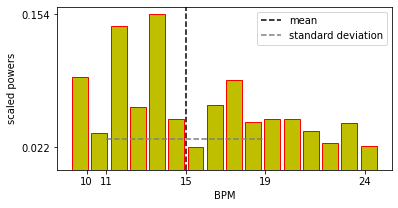

breth rate:( 15 +- 4 )BPM


In [11]:
#stimo la variabilità del rate respiratorio facendo la deviazione standard della trasformata di fourier
#per avere una stima unica faccio l'istogramma sulla somma

BPM_sum = freqG * 60
power_sum = power_coefD9A + power_coefD9G
mask_sum = (BPM_sum > 9) & (BPM_sum < 25)

power_sum = power_sum[mask_sum]
BPM_sum = BPM_sum[mask_sum]

#calcolo la media per avere un valore centrale
resp_mean = round(((BPM_sum * power_sum)/(power_sum.sum())).sum())
resp_std = round(np.sqrt(((power_sum * (BPM_sum - resp_mean)**2)/(power_sum.sum())).sum()))
power_sum_norm = power_sum/power_sum.sum()

fig,ax = plt.subplots(1,1,figsize = (6,3))
ax.bar(BPM_sum,power_sum_norm, align = 'center', width = 0.8, edgecolor = 'r', color = 'y') #istogramma normalizzato
plt.xticks(ticks = [round(min(BPM_sum)), round(resp_mean - resp_std), resp_mean, resp_mean + resp_std, round(max(BPM_sum))],\
           labels=[round(min(BPM_sum)), resp_mean - resp_std, resp_mean, resp_mean + resp_std,\
                   round(max(BPM_sum))])
plt.yticks(ticks = [min(power_sum_norm),max(power_sum_norm)], labels = [round(min(power_sum_norm),3),\
                                                                        round(max(power_sum_norm),3)])
plt.axvline(round(resp_mean), linestyle = '--', color = 'black', label = 'mean')
plt.plot(np.linspace(resp_mean - resp_std, resp_mean + resp_std, 100),\
         (max(power_sum_norm)/5)*np.ones(shape = 100), linestyle = '--', color = 'gray', label = 'standard deviation')
ax.set_xlabel('BPM')
ax.set_ylabel('scaled powers')
plt.legend()
plt.show()

print('breth rate:(',resp_mean,'+-',resp_std, ')BPM')

In [9]:
#tutta questa cosa non ha senso: sto facendo una trasformata di fourier a mano.
'''
#Voglio vedere il rate di variabilità di Gyr prendendo tutti i massimi, calcolando la distanza temporale tra due punti di 
#massimo e convertirli in bpm

Gyr_indices_max = argrelextrema(coefD9G, np.greater)
Gyr_max = coefD9G[Gyr_indices_max[0]]
Gyr_time_max = data.index[Gyr_indices_max[0]].values
Gyr_time_max = Gyr_time_max[Gyr_max > 0] #questa maschera è da migliorare
#voglio implementare questa maschera: se ho due picchi vicini, tipo entro 3 secondi, voglio prendere il maggiore 
Gyr_max = Gyr_max[Gyr_max > 0]



#c'è evidentemente un problema di massimi locali: questi glitch creano problemi.

#calcolo le la distanza tra punti di massimo in secondi
Gyr_d_max = np.abs(Gyr_time_max[:-1] - Gyr_time_max[1:]) #non posso calcolare le distanze in questo modo se go quei cazzilli in mezzo


Gyr_d_max = np.abs(Gyr_time_max[:-1] - Gyr_time_max[1:])

#ci deve essere un modo più efficace
index_false_maxima = np.where(Gyr_d_max < 2)
max_dx = Gyr_max[index_false_maxima[0] + 1]
max_sx = Gyr_max[index_false_maxima[0]]
cfr = max_dx - max_sx


counter = 0
for i in index_false_maxima:
    if cfr[counter] >= 0:
        Gyr_max[i] = Gyr_max[i + 1] #+ np.abs(cfr[counter])
        Gyr_time_max[i] = Gyr_time_max[i + 1]
        Gyr_max[i + 1] = 0
        Gyr_time_max[i + 1] = 0
    if cfr[counter] < 0:
        #Gyr_max[i + 1] = Gyr_max[i]
        #Gyr_time_max[i + 1] = Gyr_time_max[i]
        Gyr_max[i + 1] = 0
        Gyr_time_max[i + 1] = 0
    counter = counter + 1

Gyr_max = np.delete(Gyr_max, np.where(Gyr_max == 0))
Gyr_time_max = np.delete(Gyr_time_max, np.where(Gyr_time_max == 0))

print(Gyr_max)

#passo ai bpm
bpm = 60/Gyr_d_max

bpm = bpm[(bpm > 0) & (bpm < 20)]
print(bpm)

fig, ax = plt.subplots(1,1)
ax.plot(data.index, coefD9G, color = 'black', label = 'Gyr_resp')
ax.scatter(Gyr_time_max, Gyr_max, label = 'local maxima')
#plt.legend(loc = 'best')
plt.show()


plt.hist(bpm, bins = 4)
#mi è venuto il forte dubbio che sto facendo una trasformata di fourier in modo artigianale: di fatto la variabilità
#del rate respiratorio altro non è che la deviazione standard del segnale trasformato.
'''

"\n#Voglio vedere il rate di variabilità di Gyr prendendo tutti i massimi, calcolando la distanza temporale tra due punti di \n#massimo e convertirli in bpm\n\nGyr_indices_max = argrelextrema(coefD9G, np.greater)\nGyr_max = coefD9G[Gyr_indices_max[0]]\nGyr_time_max = data.index[Gyr_indices_max[0]].values\nGyr_time_max = Gyr_time_max[Gyr_max > 0] #questa maschera è da migliorare\n#voglio implementare questa maschera: se ho due picchi vicini, tipo entro 3 secondi, voglio prendere il maggiore \nGyr_max = Gyr_max[Gyr_max > 0]\n\n\n\n#c'è evidentemente un problema di massimi locali: questi glitch creano problemi.\n\n#calcolo le la distanza tra punti di massimo in secondi\nGyr_d_max = np.abs(Gyr_time_max[:-1] - Gyr_time_max[1:]) #non posso calcolare le distanze in questo modo se go quei cazzilli in mezzo\n\n\nGyr_d_max = np.abs(Gyr_time_max[:-1] - Gyr_time_max[1:])\n\n#ci deve essere un modo più efficace\nindex_false_maxima = np.where(Gyr_d_max < 2)\nmax_dx = Gyr_max[index_false_maxima[0] + 